# Physics-Augmented Neural Networks for data-driven hyperelasticity

In this demo, we show how to formulate a *Physics-Augmented Neural Network* (PANN) model to learn the hyperelastic potential of a rubber material directly from experimental data.

The PANN framework {cite:p}`linden_neural_2023, maurer_utilizing_2024` embeds physical principles, such as frame invariance and polyconvexity, into the neural network architecture, ensuring that the learned strain energy function remains physically consistent while retaining the expressive power of machine learning. In particular, polyconvexity will be ensured by representing $\psi$ with a convex function of some invariants (see #REF). Representing a convex function using a neural network is possible using Input Convex Neural Networks (ICNN) {cite:p}`amos2017icnn` which have been implemented in `jaxmat.nn.incc`.

## Reference data

We demonstrate the approach using the classical **Treloar rubber data** {cite:p}`treloar1944stress`, a widely used experimental dataset for uniaxial, biaxial, and pure shear tests on natural rubber. This dataset has become a benchmark for constitutive model calibration and for validating machine-learning-based material models.

We first load the dataset [obtained from here](https://www.kaggle.com/datasets/swordfisho/treolar-dataset). To prepare it for training, we filter invalid entries and resample the stress–stretch curves by linear interpolation, obtaining $N_\text{sample}$ data points per loading case.

In the following, we work with vectors of principal stretches $\blambda=(\lambda_1,\lambda_2,\lambda_3)$. The dataset reports only the stretch in direction 1 for the three different load cases. For all load cases, we define the two other stretches, assuming isotropy and material incompressibility ($J=\lambda_1\lambda_2\lambda_3=1$), namely:

- for Uniaxial Tension (UT): $\blambda=(\lambda_1,1/\sqrt{\lambda_1},1/\sqrt{\lambda_1})$
- for Biaxial Tension (BT): $\blambda=(\lambda_1,\lambda_1,1/\lambda_1^2)$
- for Plane Tension (PT): $\blambda=(\lambda_1,1,1/\lambda_1)$

Moreover, the dataset also reports the nominal stress in direction 1 $P_1$ for all three cases. To improve the training procedure, it is best to also learn the model against the other known stress components. As Treloar's data is obtained from stretching thin sheets, we assume $P_3=0$. $P_2$ is only known for UT ($P_2=0$) and BT ($P_2=P_1$) but not for PT. Thus, we will use both UT and BT for the training using $\bP=(P_1,P_2,P_3)$ as known output data and will use PT for validation.

We load below the data set and define the corresponding training input and output dataset as well as the PT test dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from jaxmat import get_path
from jaxmat.nn.icnn import ICNN
import jax
import jax.numpy as jnp


import optimistix as optx

current_path = get_path()
data = np.loadtxt(
    current_path / "../demos/_data/Treloar_rubber.csv", skiprows=1, delimiter=","
)
stress_data = []
load_data = []
for i in range(3):
    load_data.append(data[data[:, 2 * i] != np.inf, 2 * i])
    stress_data.append(data[data[:, 2 * i] != np.inf, 2 * i + 1])


def resample(x, y, N, downsample_ratio=0.0):
    if N is None:
        return x, y
    else:
        xr = jnp.linspace(
            (1 + downsample_ratio) * min(x), (1 - downsample_ratio) * max(x), N
        )
        yr = jnp.interp(xr, x, y)
        return xr, yr


Nsample = 100
labels = [
    "simple_tension",
    "biaxial_tension",
    "plane_tension",
]
dataset = {}
for i, label in enumerate(labels):
    lamb, stress = resample(load_data[i], stress_data[i], Nsample)
    match label:
        case "simple_tension":
            stretches = jnp.vstack((lamb, 1 / jnp.sqrt(lamb), 1 / jnp.sqrt(lamb))).T
            stresses = jnp.vstack(
                (stress, jnp.zeros_like(stress), jnp.zeros_like(stress))
            ).T
        case "biaxial_tension":
            stretches = jnp.vstack((lamb, lamb, 1 / lamb**2)).T
            stresses = jnp.vstack((stress, stress, jnp.zeros_like(stress))).T
        case "plane_tension":
            stretches = jnp.vstack((lamb, jnp.ones_like(lamb), 1 / lamb)).T
            stresses = jnp.vstack(
                (stress, jnp.full_like(stress, jnp.inf), jnp.zeros_like(stress))
            ).T  # we don't have the P2 stress for plane tension
    dataset[label] = (stretches, stresses)

training_cases = ["simple_tension", "biaxial_tension"]
train_input = {key: dataset[key][0] for key in training_cases}
train_output = {key: dataset[key][1] for key in training_cases}
test_input = {key: dataset[key][0] for key in labels if key not in training_cases}
test_output = {key: dataset[key][1] for key in labels if key not in training_cases}

## Theory of PANNs

PANNs enforce physical constraints on the free-energy potential learned by the network. In particular, they guarantee:

- isotropy (or more general material symmetry classes)
- positivity of the free energy
- zero stress in the reference configuration
- polyconvexity of the free energy

Isotropy is obtained by working with the invariants $I_1,I_2,I_3$ of the right Cauchy-Green tensor $\bC=\bF\T\bF$, with  $I_1=\tr(\bC)$, $I_2=\tr(\cof(\bC))$ and $I_3=\det(\bC)=J^2$.

Polyconvexity of the free energy is an important property which ensures material stability of the structural response. It is a desirable property which is verified by most of the classical phenomenological hyperelastic models. It corresponds to the fact that the free energy hyperelastic potential $\psi(\bF)$ is a convex function of $(\bF,\cof(\bF),\det(\bF))$. This condition can be satisfied by finding a convex function of the (polyconvex-preserving) invariants of $\bC$, namely:

```{math}
\psi(\bF) = \Psi(I_1,I_2,I_3)
```

where $\Psi$ is convex in its arguments. As mentioned above, we use an ICNN to obtain a parametrized version of the convex $\Psi$ potential. However, when limiting to $I_1,I_2,I_3$, the model is not able to reproduce compressive stresses. It is thus suggested to add $-2J$ as an additional argument of the convex function $\Psi$. Thus, our parametrized free energy will be:

```{math}
\psi_{\btheta}(\bF) = \Psi_{\btheta}(I_1,I_2,I_3,-2J)
```

where $\Psi_{\btheta}$ is an ICNN of input size 4. The final layer is also constrained to enforce a positive energy. In practice, we use $\mathcal{I}=(I_1-3, I_2-3, I_3-1, -2(J-1))$ as inputs.

The second Piola-Kirchhoff (PK2) stress $\bS$ is then obtained by taking the derivative of the network with respect to $\bC$.

One issue is that the resulting stress does not necessarily vanish in the reference stress-configuration $\bC=\bI$. To achieve this the free energy is modified by adding a term so that the stress vanishes for $\bC=\bI$, see {cite:p}`linden_neural_2023` for more details. In the case of isotropic hyperelasticity, this amounts to considering:

```{math}
\Psi^\text{PANN}_\btheta(\bC) = \Psi_{\btheta}(\mathcal{I}) - \left.\dfrac{\partial \Psi_{\btheta}}{\partial \mathcal{I}}\right|_{\bC= \bI}2(J-1)
```

The resulting PK2 stress is then:

```{math}
\bS_{\btheta} =  2\dfrac{\partial \Psi_{\btheta}^\text{PANN}}{\partial \bC}
```

and the PK1 stress is $\bP_{\btheta} = \bF\bS_{\btheta}$

## Defining the PANN model

Below, we define a `PANN` module which inherits from the `ICNN` architecture. `nn_energy` implements the NN term $\Psi_{\btheta}(\mathcal{I})$ while `pann_energy` returns $\Psi_{\btheta}^\text{PANN}$. The PK2 and PK1 stresses are then easily obtaing using AD.

Finally, we use `jax.vmap` to define a batched version of the PK1 stress computation for a given PANN material model.

In [2]:
class PANN(ICNN):
    def nn_energy(self, lambC):
        I3 = jnp.prod(lambC)
        J = jnp.sqrt(I3)
        I1 = jnp.sum(lambC)
        I2 = jnp.sum(I3 / lambC)
        inputs = jnp.asarray([I1 - 3, I2 - 3, I3 - 1, -2 * (J - 1)])
        return super().__call__(inputs)

    def pann_energy(self, lambC):
        J = jnp.sqrt(jnp.prod(lambC))
        dpsi_dC = jax.jacfwd(self.nn_energy)(jnp.ones((3,)))[0]
        return self.nn_energy(lambC) - 2 * dpsi_dC * (J - 1)

    def pann_PK2_stress(self, lambC):
        dpsi_dC = jax.jacfwd(self.pann_energy)
        return 2 * dpsi_dC(lambC)

    def pann_PK1_stress(self, stretches):
        return jnp.diag(stretches) @ self.pann_PK2_stress(stretches**2)

    def __call__(self, lambC):
        return self.pann_energy(lambC) - self.pann_energy(jnp.ones((3,)))


batched_compute_stress = jax.vmap(PANN.pann_PK1_stress, in_axes=(None, 0))

A PANN material with 10 neurons in one hidden layer is defined below and randomly initialized. The figure reports the stress-stretch curve for uniaxial tension obtained with this initialization. As expected, the stress is zero in the reference configuration.

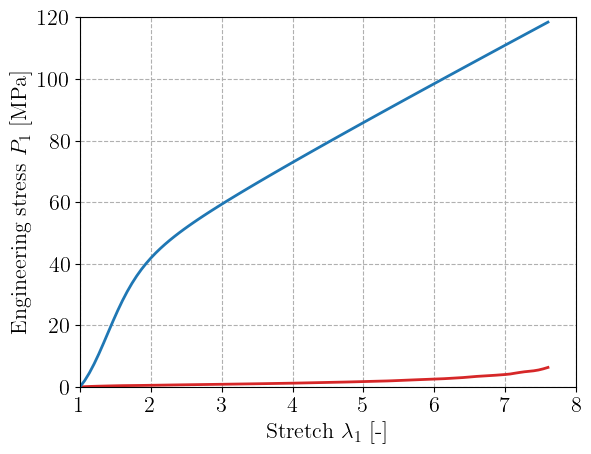

In [3]:
input_dim = 4
hidden_dims = [10]
key = jax.random.PRNGKey(42)
material = PANN(input_dim, hidden_dims, key)

stretches_ST = train_input["simple_tension"]
PK1_ST = batched_compute_stress(material, stretches_ST)

plt.figure()
plt.plot(
    stretches_ST[:, 0],
    train_output["simple_tension"][:, 0],
    "-C3",
    label="Training data",
)
plt.plot(stretches_ST[:, 0], PK1_ST[:, 0], label="Initial prediction")
plt.xlabel(r"Stretch $\lambda_1$ [-]")
plt.ylabel("Engineering stress $P_1$ [MPa]")
plt.show()

## Training the PANN model

We are now ready to set up the training. Here, we simply define the error between the predicted and the stress data and use `optimistix` least-square solvers. First, the total error is defined by mapping the `error` function over the training load cases defined as a PyTree. The `total_error` takes as a first argument the PANN model PyTree `material` while training data are stored in the second `args` argument.

In [4]:
def total_error(material, args):
    input, output = args

    def error(input, output):
        PK1 = batched_compute_stress(material, input)
        return PK1 - output

    return jax.tree.map(error, input, output)

We use a BFGS solver to solve the least-square problem and we do not throw an error in case we reach the maximum number of steps. We retrieve the final trained PANN model from `sol.value`.

In [5]:
solver = optx.BFGS(
    rtol=1e-6,
    atol=1e-8,
    # verbose=frozenset({"loss", "step_size"}),
)

sol = optx.least_squares(
    total_error,
    solver,
    material,
    args=(train_input, train_output),
    throw=False,
    max_steps=10000,
)
trained_PANN = sol.value

## Results

We plot the resulting predicted stresses for the two training load cases (Simple and Biaxial Tension) and also evaluate the performance on the unseen Plane Tension load case. The PANN architecture succeeds in learning a good representation of the data, while ensuring almost zero out-of-plane stress in general. The prediction is still very good even on the unseen Plane Tension case.

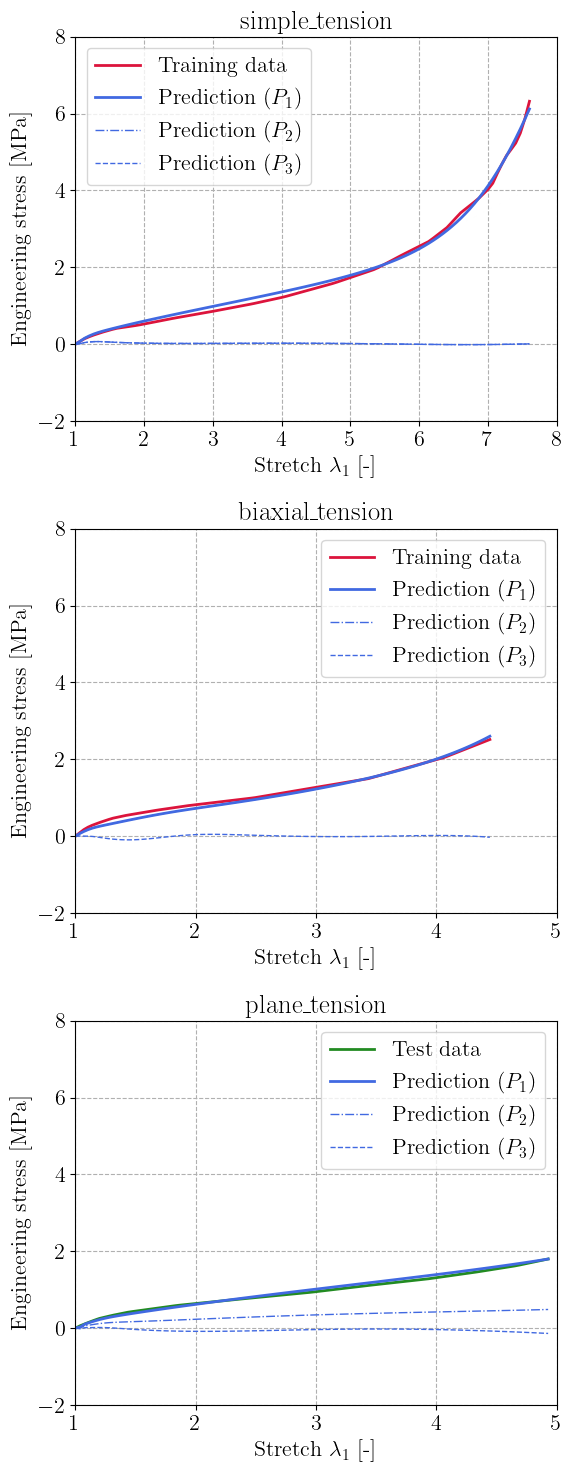

In [6]:
m = len(labels)
plt.figure(figsize=(6, 5 * m))
for i, label in enumerate(labels):
    stretches, stresses = dataset[label]
    PK1 = batched_compute_stress(trained_PANN, stretches)
    plt.subplot(m, 1, i + 1)
    plt.title(label)
    if label in training_cases:
        dtype = "Training data"
        color = "crimson"
    else:
        dtype = "Test data"
        color = "forestgreen"
    plt.plot(stretches[:, 0], stresses[:, 0], color=color, label=dtype)
    plt.plot(stretches[:, 0], PK1[:, 0], color="royalblue", label="Prediction ($P_1$)")
    plt.plot(
        stretches[:, 0],
        PK1[:, 1],
        "-.",
        color="royalblue",
        linewidth=1,
        label="Prediction ($P_2$)",
    )
    plt.plot(
        stretches[:, 0],
        PK1[:, 2],
        "--",
        color="royalblue",
        linewidth=1,
        label="Prediction ($P_3$)",
    )
    plt.xlabel(r"Stretch $\lambda_1$ [-]")
    plt.ylabel("Engineering stress [MPa]")
    plt.gca().set_xlim(1.0)
    plt.gca().set_ylim(-2, 8.0)
    plt.legend()
plt.tight_layout()
plt.show()

## References

```{bibliography}
:filter: docname in docnames
```